In [1]:
# %pip install datasets
# %pip install 'accelerate>=0.26.0'
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install torch
# %pip install transformers
# %pip install scikit-learn
# %pip install datasets
# %pip install kagglehub
# %pip install ipywidgets
# %pip install pylatexenc

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import kagglehub

import warnings
warnings.filterwarnings('ignore')

#### Data processing

In [3]:
file_path = kagglehub.dataset_download("lizhecheng/llm-science-dataset")
data = pd.read_csv(f"{file_path}/High Quality Dataset.csv")

X = data['prompt'].values
y = data['answer'].values

label_to_id = {label: idx for idx, label in enumerate(np.unique(y))}
id_to_label = {idx: label for label, idx in label_to_id.items()}
y = np.array([label_to_id[label] for label in y])

label_counts = pd.Series(y).value_counts()
single_instance_labels = label_counts[label_counts == 1].index
filtered_data = data[~data['answer'].isin(single_instance_labels)]

X = filtered_data['prompt'].values
y = filtered_data['answer'].values

label_to_id = {label: idx for idx, label in enumerate(np.unique(y))}
y = np.array([label_to_id[label] for label in y])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Tokenization

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

train_data = {'text': X_train, 'label': y_train}
test_data = {'text': X_test, 'label': y_test}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/7068 [00:00<?, ? examples/s]

Map:   0%|          | 0/1767 [00:00<?, ? examples/s]

#### Model and Training Arguments

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_to_id),
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=10,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train the Model

In [6]:
print("Starting NLP Training...")
trainer.train()

results = trainer.evaluate()
print("Evaluation Results:", results)

Starting NLP Training...


Epoch,Training Loss,Validation Loss
1,1.635800,1.610516
2,1.568200,1.623855
3,1.586900,1.637888
4,1.257200,1.893514
5,0.884500,2.224656


Evaluation Results: {'eval_loss': 2.224656105041504, 'eval_runtime': 34.0091, 'eval_samples_per_second': 51.957, 'eval_steps_per_second': 3.264, 'epoch': 5.0}


#### Inference

In [10]:
device = torch.device("mps" if torch.has_mps else "cpu")
model.to(device)

def predict(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
    encodings = {key: val.to(device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1)
    return [id_to_label[pred.item()] for pred in predictions]

#### Example Inference

In [11]:
sample_texts = ["What is quantum entanglement?", "Explain Modified Newtonian Dynamics."]
predictions = predict(sample_texts)
print("Predictions:", predictions)

Predictions: ['A', 'A']


#### Evaluate with Test Data

In [12]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

y_pred_labels = [id_to_label[pred] for pred in y_pred]
y_true_labels = [id_to_label[true] for true in y_true]

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2405


In [13]:
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("\nConfusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           A       0.31      0.33      0.32       423
           B       0.20      0.23      0.21       355
           C       0.22      0.29      0.25       357
         C         0.00      0.00      0.00         1
           D       0.24      0.22      0.23       325
         D         0.00      0.00      0.00         1
           E       0.23      0.11      0.15       305

    accuracy                           0.24      1767
   macro avg       0.17      0.17      0.16      1767
weighted avg       0.24      0.24      0.24      1767


Confusion Matrix:
[[138  82 112   0  55   0  36]
 [ 97  81  91   0  55   0  31]
 [ 83  77 102   0  65   0  30]
 [  1   0   0   0   0   0   0]
 [ 52  91  92   0  70   0  20]
 [  1   0   0   0   0   0   0]
 [ 74  78  72   0  47   0  34]]


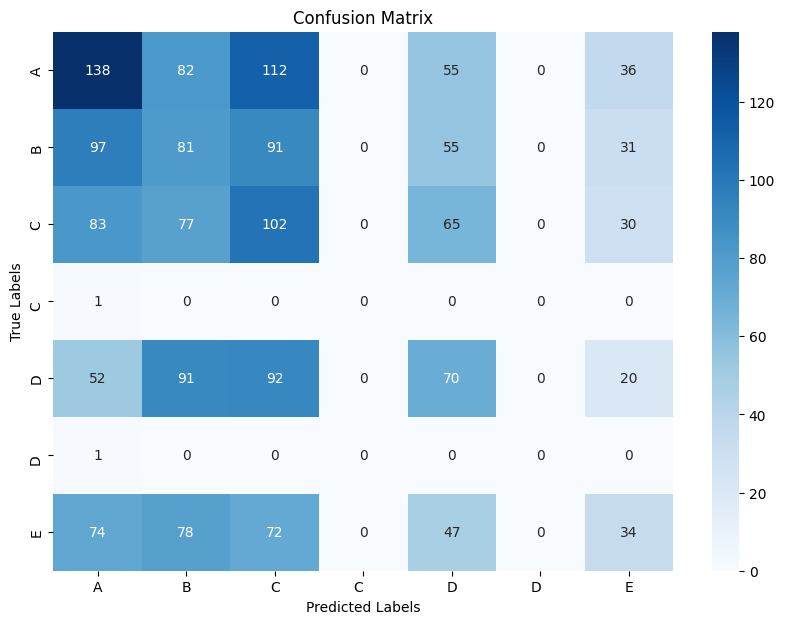

In [14]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_true_labels), 
            yticklabels=np.unique(y_true_labels))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()